# Creating customers segments using different clustering algorithms
----
In this unsupervised learning project, we create customer segments using different clustering methods. We start by normalising the data and having a look at outliers. We then reduce the dimensionality of the data by applying a PCA and we try different clustering algorithms:
- K-Means
- Gaussian mixture model
- Agglomerative clustering
- DBSCAN

The dataset used in this project is from the UCI Machine Learning repository and it is available [here](https://archive.ics.uci.edu/ml/datasets/Wholesale+customers). It contains 440 instances of annual spending by clients of a wholesale distributor on 6 product categories.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
% matplotlib inline
from scipy import stats
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score

In [2]:
# loading the dataset
data= pd.read_csv("wholesale_data.csv")
print("Data shape: ", data.shape)
data.head()

Data shape:  (440, 6)


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,12669,9656,7561,214,2674,1338
1,7057,9810,9568,1762,3293,1776
2,6353,8808,7684,2405,3516,7844
3,13265,1196,4221,6404,507,1788
4,22615,5410,7198,3915,1777,5185


In [3]:
# statistics
data.describe()

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
count,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000
mean,12000.297727,5796.265909,7951.277273,3071.931818,2881.493182,1524.870455
std,12647.328865,7380.377175,9503.162829,4854.673333,4767.854448,2820.105937
min,3.000000,55.000000,3.000000,25.000000,3.000000,3.000000
25%,3127.750000,1533.000000,2153.000000,742.250000,256.750000,408.250000
50%,8504.000000,3627.000000,4755.500000,1526.000000,816.500000,965.500000
75%,16933.750000,7190.250000,10655.750000,3554.250000,3922.000000,1820.250000
max,112151.000000,73498.000000,92780.000000,60869.000000,40827.000000,47943.000000


The count row of the table indicates that we don't have any missing values. We also note that all entries are positive numbers, which was expected since they represent counts of products that have been sold to customers. For each product category, the comparison of the mean, min and max values, along with the different quartiles, suggests that we might have a number of outliers in the dataset. We will take a look at them in a moment.

----
## Data preprocessing

Using `pairplot` from Seaborn, we can plot the distribution of each feature and the possible correlation between product categories.

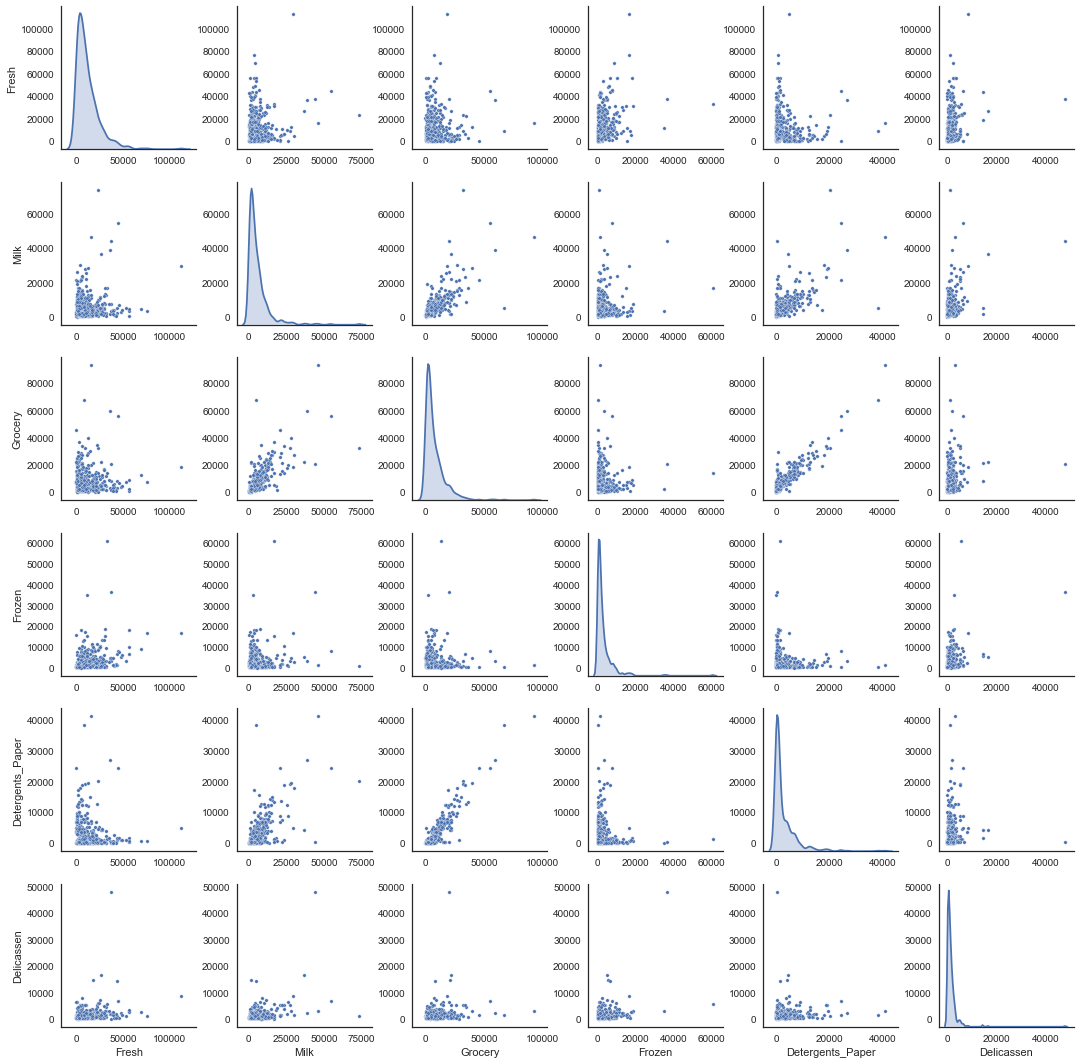

In [4]:
# scatter matrix of product categories
sns.set()
sns.set_style("white")
sns.pairplot(data, diag_kind="kde", diag_kws=dict(shade=True), markers=".")

We can tell that a few features exhibit some degree of correlation: i) Grocery and Milk, ii) Grocery and Detergents_Paper and iii) Milk and Detergents_paper.

We also note that the data is not normally distributed. For each product category, most customer spending is located in the first few intervals, which leads to a distribution that is skewed to the right. Let's apply a Box-Cox transformation to our data in order to reduce its skewness.

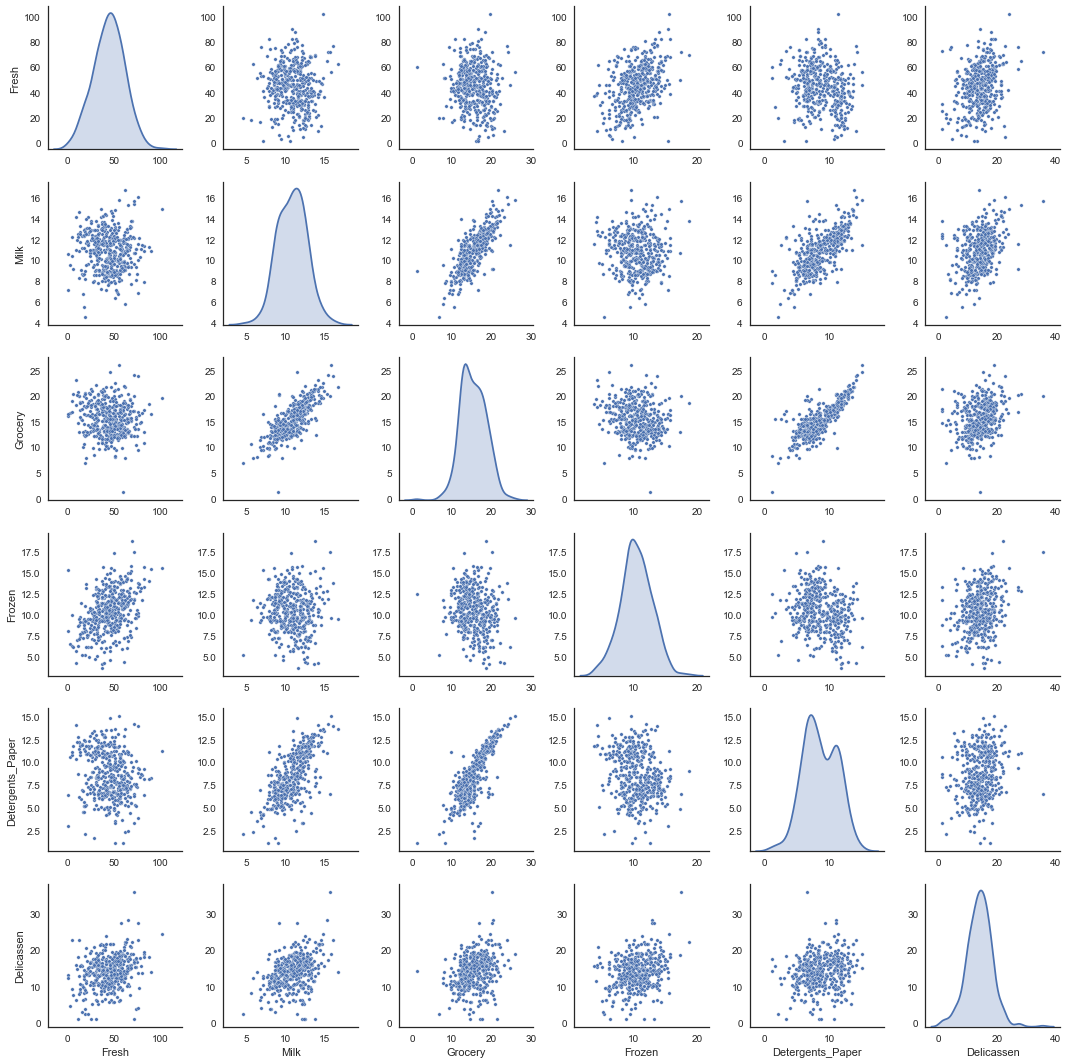

In [5]:
# Box-Cox transformation
norm_df= data.copy()
for feature in norm_df.columns:
    norm_df[feature]= stats.boxcox(norm_df[feature])[0]
norm_df.head()

# scatter matrix of product categories after transformation
sns.set_style("white")
sns.pairplot(norm_df, diag_kind="kde", diag_kws=dict(shade=True), markers=".")

After a Box-Cox transformation, our data is indeed more normally distributed.

It can be useful to identify outliers in the data. We will use Tukey's method: outliers are the data points that are below Q1 - 1.5 \* IQR or above Q3 + 1.5 \* IQR (where Q1 is the first quartile, Q3 is the third quartile and IQR is the interquartile range).

In [6]:
outliers= []
for feature in norm_df.columns:
    Q1= np.percentile(norm_df[feature], 25)
    Q3= np.percentile(norm_df[feature], 75)
    step= 1.5 * (Q3-Q1)
    outliers_df= pd.concat([norm_df[norm_df[feature]<Q1-step] , norm_df[norm_df[feature]>Q3+step]])
    outliers_df= outliers_df.sort_index()
    outliers.append(outliers_df.index.tolist())
outliers

[[181],
 [86, 154],
 [75, 85],
 [38, 57, 65, 93, 145, 183, 325, 420],
 [],
 [23, 71, 87, 109, 128, 142, 154, 183, 184, 187, 233]]

There are a few outliers in the dataset but none of them is repeated more than twice (ie outlier for more than 2 product categories). Deciding whether to keep outliers or not is context-dependent. For the purpose of this project, we will keep the full set of data points.

----
## Dimensionality reduction with PCA

Before doing any clustering, we can reduce the dimensionality of our data by doing a PCA. It is indeed convenient to be able to plot the data in 2 dimensions. Let's start with a PCA with 6 principle components in order to have a look at the variance captured by each of them.

In [7]:
# PCA with 6 principle components
pca6= PCA(n_components=6)
pca6.fit(norm_df)
pca6_results= pca6.transform(norm_df)
pca6_df= pd.DataFrame(pca6_results, columns=["PC1", "PC2", "PC3", "PC4", "PC5", "PC6"])
pca6_df.head()

,PC1,PC2,PC3,PC4,PC5,PC6
0,6.671112,2.528633,-2.293693,3.489904,-0.113735,1.164966
1,-1.738497,4.225749,-0.242836,-0.321075,-0.198567,0.658707
2,-2.555656,8.983817,5.158418,0.663956,-1.105659,0.428669
3,8.021228,0.529513,2.853043,-1.575260,-0.300156,-1.637725
4,17.719555,5.992199,2.856885,0.206540,-0.598638,-0.235939


In [8]:
# explained variance ratio
pca6.explained_variance_ratio_

array([ 0.86899784,  0.07213426,  0.03781381,  0.01336331,  0.0044985 ,
        0.00319229])

From the array above, we can tell that the first and second principle components explain 94% of the variance in our data. Therefore, we can reduce the dimensionality of the data from 6 to 2 dimensions while keeping most of the variance.

In [9]:
# only keeping the first 2 principle components
pca_df= pca6_df[["PC1", "PC2"]]
pca_df.head()

,PC1,PC2
0,6.671112,2.528633
1,-1.738497,4.225749
2,-2.555656,8.983817
3,8.021228,0.529513
4,17.719555,5.992199


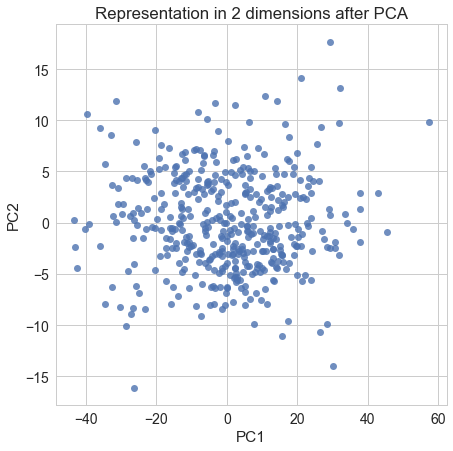

In [10]:
# visualising the data in 2 dimensions
plt.figure(figsize=(7, 7))
sns.set(font_scale=1.4)
sns.set_style("whitegrid")
sns.regplot("PC1", "PC2", data=pca_df, fit_reg=False)
plt.title("Representation in 2 dimensions after PCA")
plt.show()

----
## Clustering

### K-means

To find customer segments in the data, we'll use different clustering algorithms. One of the most popular is K-means. A downside of this algorithm is that we have to specify the number of clusters that we want the algorithm to find. Because we don't have a predefined number of clusters for this project, we will use the [silhouette score](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html) to help us choose a number.

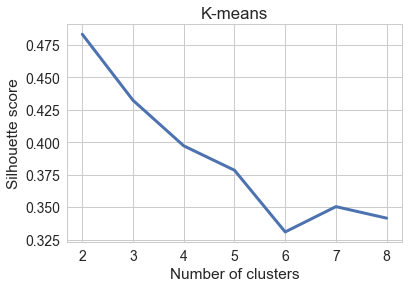

In [11]:
# computing labels for different cluster numbers with K-means
data_with_clusters= pca_df.copy()
km_scores= {}
for i in range(2,9):
    kmeans= KMeans(n_clusters=i, random_state=0).fit(pca_df)
    # storing cluster labels
    km_labels= kmeans.labels_
    data_with_clusters["K-means"+str(i)+"clusters"]= km_labels
    # silhouette score
    km_scores[i]= silhouette_score(pca_df, km_labels)
    
# plotting scores
plt.plot(km_scores.keys(), km_scores.values(), lw=3)
plt.title("K-means")
plt.xlabel("Number of clusters")
plt.ylabel("Silhouette score")
plt.show()

The highest silhouette score is obtained when the data is divided into 2 clusters. Let's have a look at these clusters.

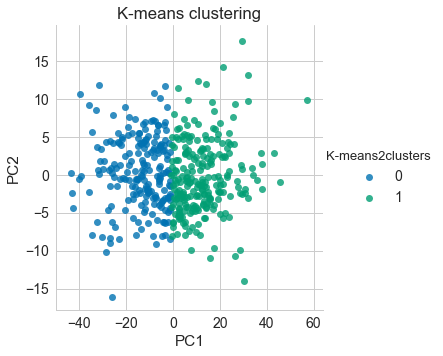

In [12]:
# visualising clusters obtained with K-means
sns.lmplot(x="PC1", y="PC2", data=data_with_clusters, hue="K-means2clusters", fit_reg=False, palette="colorblind")
plt.title("K-means clustering")
plt.show()

Because the data is not clearly separable, K-means may not be the best candidate clustering algorithm. Indeed, K-means works well for globular, well-separated clusters that have similiar sizes.

Plus, K-means performs hard cluster assignments. In our case, it would be more appropriate to use an algorithm that is able to capture uncertainty about cluster assignments, such as a Gaussian mixture model.

### Gaussian mixture model

A mixture model is a probabilistic approach which provides soft assignments of data points to clusters. These soft assignments account for both uncertainty in these cluster assignments and different cluster shapes.

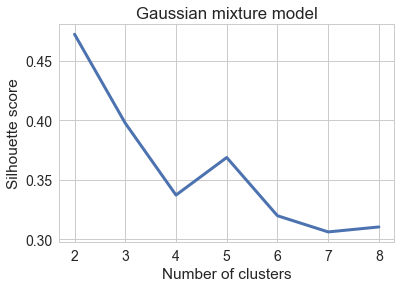

In [13]:
# computing labels for different cluster numbers with a Gaussian mixture model
gm_scores= {}
for i in range(2,9):
    gm= GaussianMixture(n_components=i, random_state=0)
    gm.fit(pca_df)
    # storing cluster labels
    gm_labels= gm.predict(pca_df)
    data_with_clusters["GaussianMixture"+str(i)+"clusters"]= gm_labels
    # silhouette score
    gm_scores[i]= silhouette_score(pca_df, gm_labels)

# plotting scores
plt.plot(gm_scores.keys(), gm_scores.values(), lw=3)
plt.title("Gaussian mixture model")
plt.xlabel("Number of clusters")
plt.ylabel("Silhouette score")
plt.show()

As with K-means, the best silhouette score corresponds to 2 clusters.

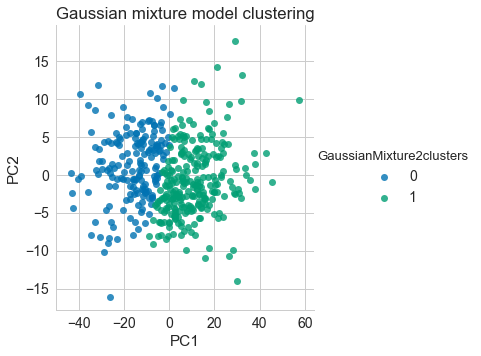

In [14]:
# visualising clusters obtained with a Gaussian mixture model
sns.lmplot(x="PC1", y="PC2", data=data_with_clusters, hue="GaussianMixture2clusters", fit_reg=False, palette="colorblind")
plt.title("Gaussian mixture model clustering")
plt.show()

As we can see, the clusters above are different from the ones we obtained with K-means. In particular, points located in between clusters are now assigned to the green cluster.

### Agglomerative Clustering

Hierarchical clustering algorithms build clusters by merging or splitting clusters successively. Agglomerative clustering is a member of this group: at the start, each data point is in its own cluster, and the algorithm merges similar clusters into new clusters until there is only one cluster left, that contains all the data points. We then have to choose how many clusters we are interested in seeing.

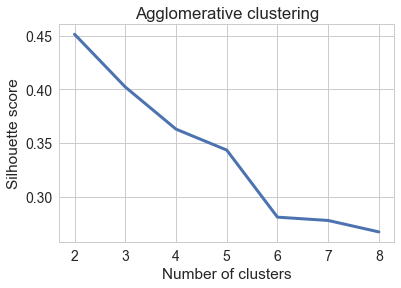

In [15]:
# computing labels for different cluster numbers with the Agglomerative Clustering algorithm
agg_scores= {}
for i in range(2,9):
    agg= AgglomerativeClustering(n_clusters=i).fit(pca_df)
    agg_labels= agg.labels_
    data_with_clusters["AgglomerativeClustering"+str(i)+"clusters"]= agg_labels
    # silhouette score
    agg_scores[i]= silhouette_score(pca_df, agg_labels)

# plotting scores
plt.plot(agg_scores.keys(), agg_scores.values(), lw=3)
plt.title("Agglomerative clustering")
plt.xlabel("Number of clusters")
plt.ylabel("Silhouette score")
plt.show()

The highest silhouette score is obtained with 2 clusters as well.

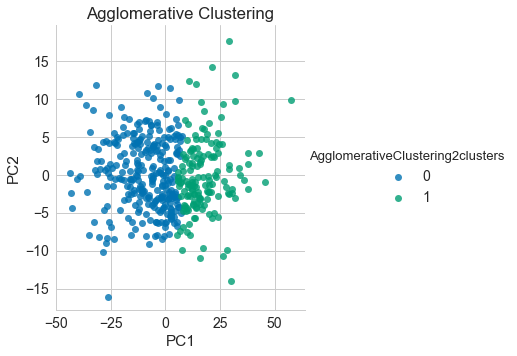

In [16]:
# visualising clusters obtained with Agglomerative clustering
sns.lmplot("PC1", "PC2", data=data_with_clusters, hue="AgglomerativeClustering2clusters", fit_reg=False, palette="colorblind")
plt.title("Agglomerative Clustering")
plt.show()

Using this hierarchical clustering approach, the majority of data points is assigned to the blue cluster. 

Another clustering method we will try is a density-based clustering technique: DBSCAN.

### DBSCAN (Density-Based Spatial Clustering of Applications with Noise)

One of the advantages of DBSCAN is that we do not need to specify a number of clusters. The algorithm assigns data points to clusters based on their density. Therefore, DBSCAN works well in the case of complex cluster shapes. Note that data points that cannot be assigned to clusters are labelled as noise.

The main parameters we have to tune are the minimum number of points per cluster and the maximum distance between 2 points for them to be considered as located in the same dense region. We will pick 5 points as the minimum number of points per cluster and vary the maximum distance.

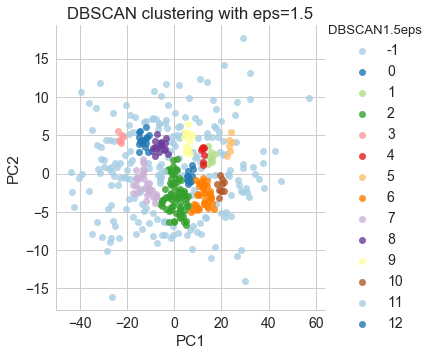

In [17]:
# DBSCAN clustering with different maximum distances (eps parameter)
for eps in [1.5, 2]:
    dbscan= DBSCAN(eps=eps)
    dbscan_labels= dbscan.fit_predict(pca_df)
    data_with_clusters["DBSCAN"+str(eps)+"eps"]= dbscan_labels

# visualising DBSCAN clustering for eps=1.5
sns.lmplot(x="PC1", y="PC2", data=data_with_clusters, hue="DBSCAN1.5eps", fit_reg=False, palette="Paired")
plt.title("DBSCAN clustering with eps=1.5")
plt.show()

With the eps parameter set at 1.5, DBSCAN is able to find 13 clusters. The data points that cannot be assigned to clusters are labelled -1 (noise). Let's have a look at the clustering when eps is 2.

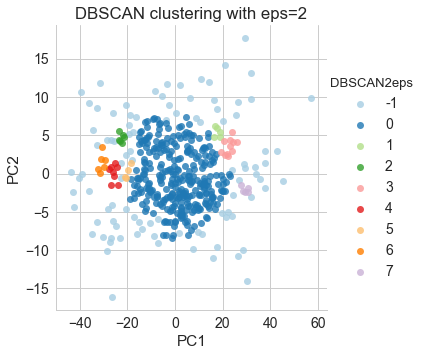

In [18]:
# visualising DBSCAN clustering for eps=2
sns.lmplot(x="PC1", y="PC2", data=data_with_clusters, hue="DBSCAN2eps", fit_reg=False, palette="Paired")
plt.title("DBSCAN clustering with eps=2")
plt.show()

On the above plot, we can see the 8 clusters that DBSCAN is able to find when eps is 2. We can tell that DBSCAN creates clusters that can be of different shapes and sizes: the first cluster (cluster number 0) contains the vast majority of the data points that have been assigned to clusters. 

----
## Conclusion

In this project, we have explored different clustering algorithms: K-means, Gaussian mixture, Agglomerative clustering and DBSCAN. Even though the first three gave similar results, the clusters we obtained were different for each algorithm. 

In the case of unsupervised learning, having no ground truth means that there is no correct answer in terms of cluster assignment or cluster numbers. Multiple clusterings are often plausible for the same dataset, as seen in this project. In order to evaluate clustering quality, we can consider a task-based evaluation: we assess clusters quality according to how well clustering-based features improve the performance of a following supervised learning task. 